# Imports and Setup

In [2]:
import os
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
import cv2
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers

# Use tf_keras instead of keras for inceptioV1
import tf_keras
from tf_keras import layers as tf_layers
from tf_keras import models as tf_models
from tf_keras import optimizers as tf_optimizers
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_curve, auc)
import shutil
from sklearn.utils import shuffle
import random

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data_dir = '/kaggle/input/eurosat-dataset/EuroSAT'

classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway','Industrial', 
           'Pasture', 'PermanentCrop', 'Residential','River', 'SeaLake']

num_classes = 10
IMG_SIZE = 224
batch_size = 32
epochs = 15
IMAGES_PER_CLASS = 1000

# Explore Dataset

In [4]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count
    print(f"{class_name}: {count} images")

sum(class_counts.values())

AnnualCrop: 3000 images
Forest: 3000 images
HerbaceousVegetation: 3000 images
Highway: 2500 images
Industrial: 2500 images
Pasture: 2000 images
PermanentCrop: 2500 images
Residential: 3000 images
River: 2500 images
SeaLake: 3000 images


27000

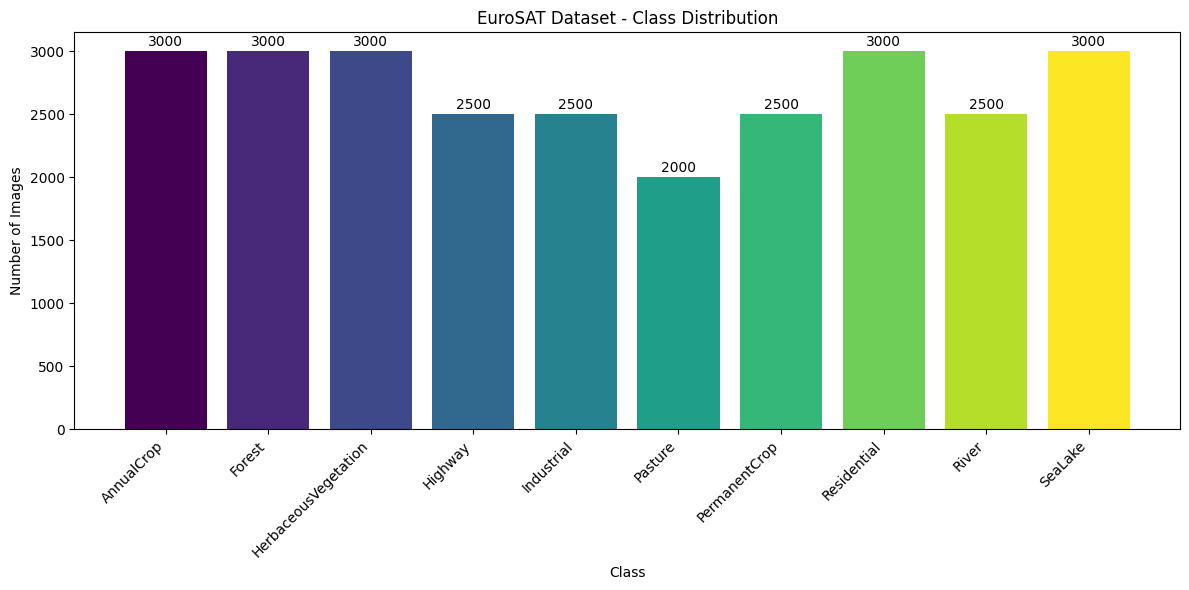

In [5]:
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('EuroSAT Dataset - Class Distribution')
for bar, count in zip(bars, class_counts.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            str(count), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Load All Data

In [6]:
data = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    all_images = os.listdir(class_path)
    np.random.seed(42)
    np.random.shuffle(all_images)
    
    selected_images = all_images[:IMAGES_PER_CLASS]
    
    for img_name in selected_images:
        img_path = os.path.join(class_path, img_name)
        data.append(img_path)
        labels.append(class_name)
    
    print(f"{class_name}: {len(selected_images)} images selected")

total_images = len(data)
print(f" \n\nTotal balanced images: {total_images}")

data, labels = shuffle(data, labels, random_state=42)

AnnualCrop: 1000 images selected
Forest: 1000 images selected
HerbaceousVegetation: 1000 images selected
Highway: 1000 images selected
Industrial: 1000 images selected
Pasture: 1000 images selected
PermanentCrop: 1000 images selected
Residential: 1000 images selected
River: 1000 images selected
SeaLake: 1000 images selected
 

Total balanced images: 10000


# Label Encoding

In [7]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)    #  <------------------------------------------
CLASS_NAMES = label_encoder.classes_

print("\nLabel Mapping:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {i} -> {class_name}")


Label Mapping:
  0 -> AnnualCrop
  1 -> Forest
  2 -> HerbaceousVegetation
  3 -> Highway
  4 -> Industrial
  5 -> Pasture
  6 -> PermanentCrop
  7 -> Residential
  8 -> River
  9 -> SeaLake


## Balanced with Down sample

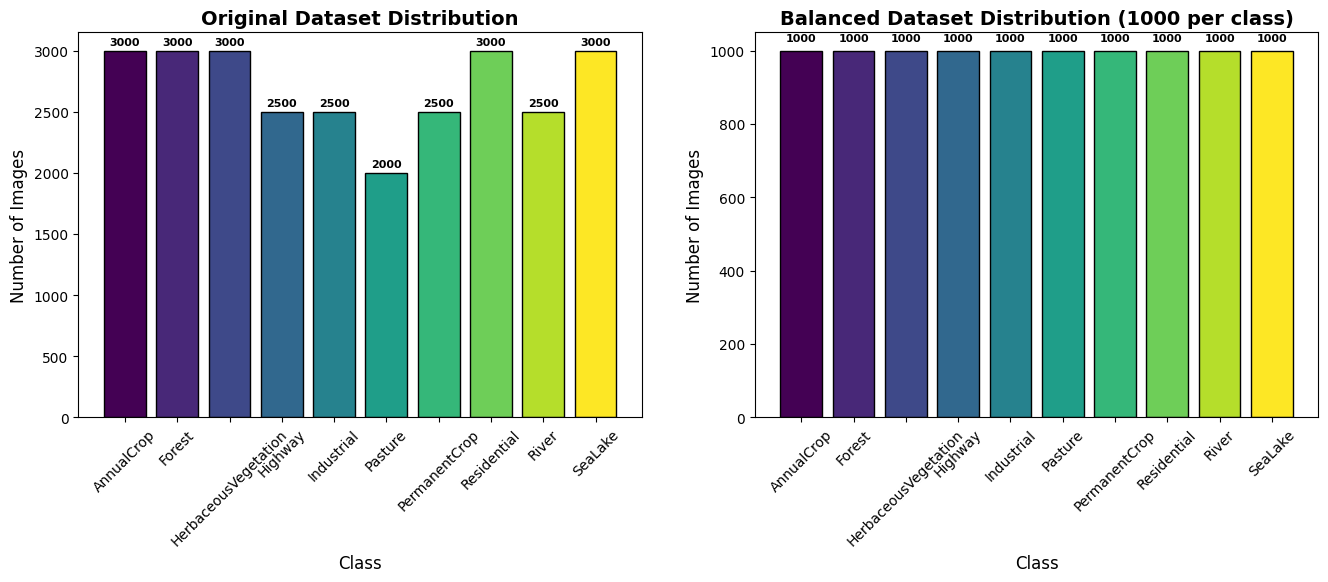

In [8]:
balanced_counts = {class_name: IMAGES_PER_CLASS for class_name in classes}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original distribution
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
bars1 = axes[0].bar(class_counts.keys(), class_counts.values(), color=colors, edgecolor='black')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Original Dataset Distribution', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars1, class_counts.values()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                str(count), ha='center', va='bottom', fontsize=8, fontweight='bold')

bars2 = axes[1].bar(balanced_counts.keys(), balanced_counts.values(), color=colors, edgecolor='black')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_title(f'Balanced Dataset Distribution ({IMAGES_PER_CLASS} per class)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                str(IMAGES_PER_CLASS), ha='center', va='bottom', fontsize=8, fontweight='bold')


plt.show()

# Split Data - Train 70%, Val 15%, Test 15%

In [9]:
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    data, labels_encoded, test_size=0.3, random_state=42, stratify=labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"  Training:   {len(X_train_paths):,} samples ({len(X_train_paths)/len(data)*100:.1f}%)")
print(f"  Validation: {len(X_val_paths):,} samples ({len(X_val_paths)/len(data)*100:.1f}%)")
print(f"  Testing:    {len(X_test_paths):,} samples ({len(X_test_paths)/len(data)*100:.1f}%)")

  Training:   7,000 samples (70.0%)
  Validation: 1,500 samples (15.0%)
  Testing:    1,500 samples (15.0%)


# Class Distribution per Split

In [10]:
train_dist = pd.Series(y_train).value_counts().sort_index()
val_dist = pd.Series(y_val).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()
class_indices = list(range(len(CLASS_NAMES)))

distribution_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Train': [train_dist.get(c, 0) for c in class_indices],
    'Validation': [val_dist.get(c, 0) for c in class_indices],
    'Test': [test_dist.get(c, 0) for c in class_indices]
})
distribution_df

Class  Train  Validation  Test
0            AnnualCrop    700         150   150
1                Forest    700         150   150
2  HerbaceousVegetation    700         150   150
3               Highway    700         150   150
4            Industrial    700         150   150
5               Pasture    700         150   150
6         PermanentCrop    700         150   150
7           Residential    700         150   150
8                 River    700         150   150
9               SeaLake    700         150   150

# Show one sample from each class

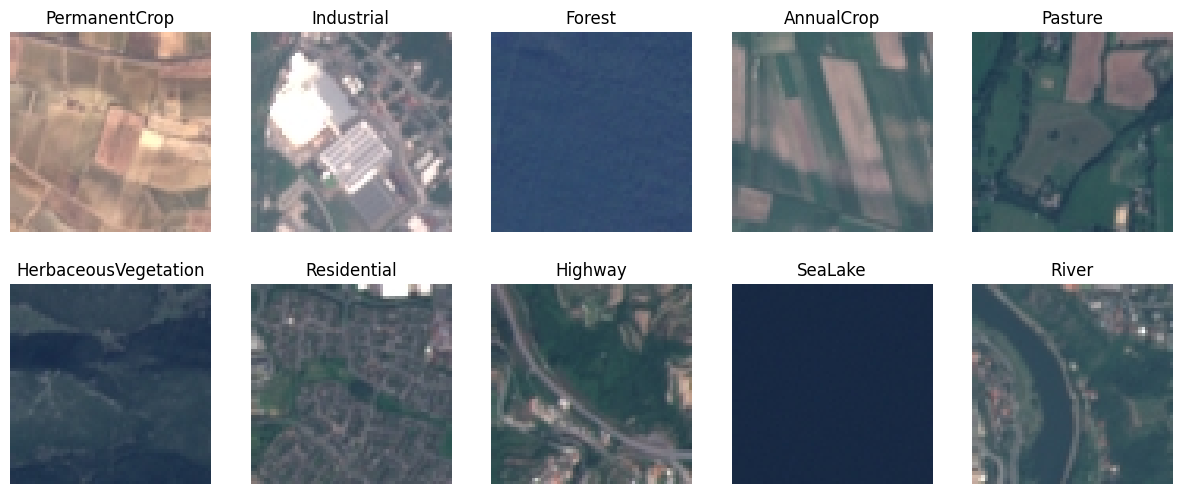

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

shown_classes = []
idx = 0
for img_path, label in zip(data,labels):
    if label not in shown_classes:
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(label)
        axes[idx].axis('off')
        shown_classes.append(label)
        idx += 1
    if idx >= 10:
        break

plt.show()

# Load and Preprocess & Augentation Images 

In [12]:
def augment_image(image):
    image = np.clip(image, 0, 1)

    image = Image.fromarray((image * 255).astype(np.uint8))
    image = ImageEnhance.Brightness(image).enhance(1.08)

    image = ImageEnhance.Contrast(image).enhance(1.12)

    image = ImageEnhance.Color(image).enhance(1.05)

    image = ImageEnhance.Sharpness(image).enhance(1.15)

    image = np.array(image).astype(np.float32) / 255.0
    return image

In [13]:
def load_and_preprocess_image(image_path, augment=False):
    """Optimized image loading with optional augmentation"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    
    if augment:
        img = augment_image(img)
    
    return img

In [14]:
X_train = np.array([
    load_and_preprocess_image(img_path, augment=True)
    for img_path in tqdm(X_train_paths, desc="Training")
], dtype=np.float32)

X_val = np.array([
    load_and_preprocess_image(img_path, augment=False)
    for img_path in tqdm(X_val_paths, desc="Validation")
], dtype=np.float32)


X_test = np.array([
    load_and_preprocess_image(img_path, augment=False)
    for img_path in tqdm(X_test_paths, desc="Testing")
], dtype=np.float32)

Testing: 100%|██████████| 1500/1500 [00:03<00:00, 428.55it/s]


In [15]:
def visualize_augmented_samples(image_paths, labels, classes, num_samples=8):
    assert num_samples <= len(image_paths), "num_samples exceeds available data"
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2.5))
    
    # Handle single row case
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        img_path = image_paths[i]
        label = labels[i]
        
        # Handle both integer indices and string labels
        if isinstance(label, (int, np.integer)):
            label_name = classes[label]
        else:
            # If label is already a string
            label_name = str(label)
        
        # Load original and augmented versions
        original_img = load_and_preprocess_image(img_path, augment=False)
        augmented_img = load_and_preprocess_image(img_path, augment=True)
        
        # Ensure values are in [0,1]
        original_img = np.clip(original_img, 0, 1)
        augmented_img = np.clip(augmented_img, 0, 1)
        
        # Plot original
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original - {label_name}", fontsize=10)
        axes[i, 0].axis("off")
        
        # Plot augmented
        axes[i, 1].imshow(augmented_img)
        axes[i, 1].set_title("Augmented", fontsize=10)
        axes[i, 1].axis("off")
    
    plt.suptitle("Original vs Augmented Images", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

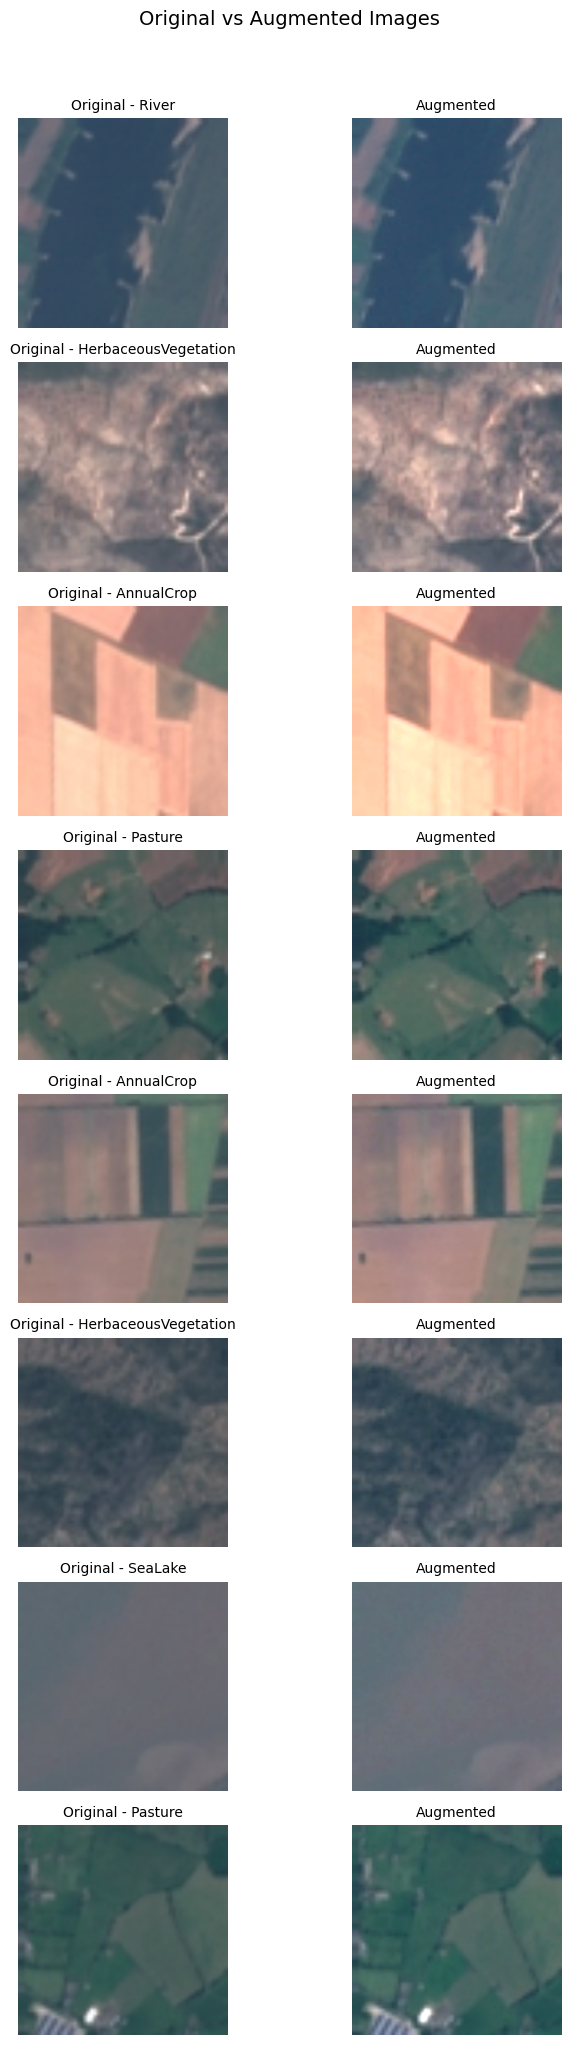

In [16]:
visualize_augmented_samples(X_train_paths[:8],y_train[:8],classes,num_samples=8)


In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(7000, 224, 224, 3) (7000,)
(1500, 224, 224, 3) (1500,)
(1500, 224, 224, 3) (1500,)


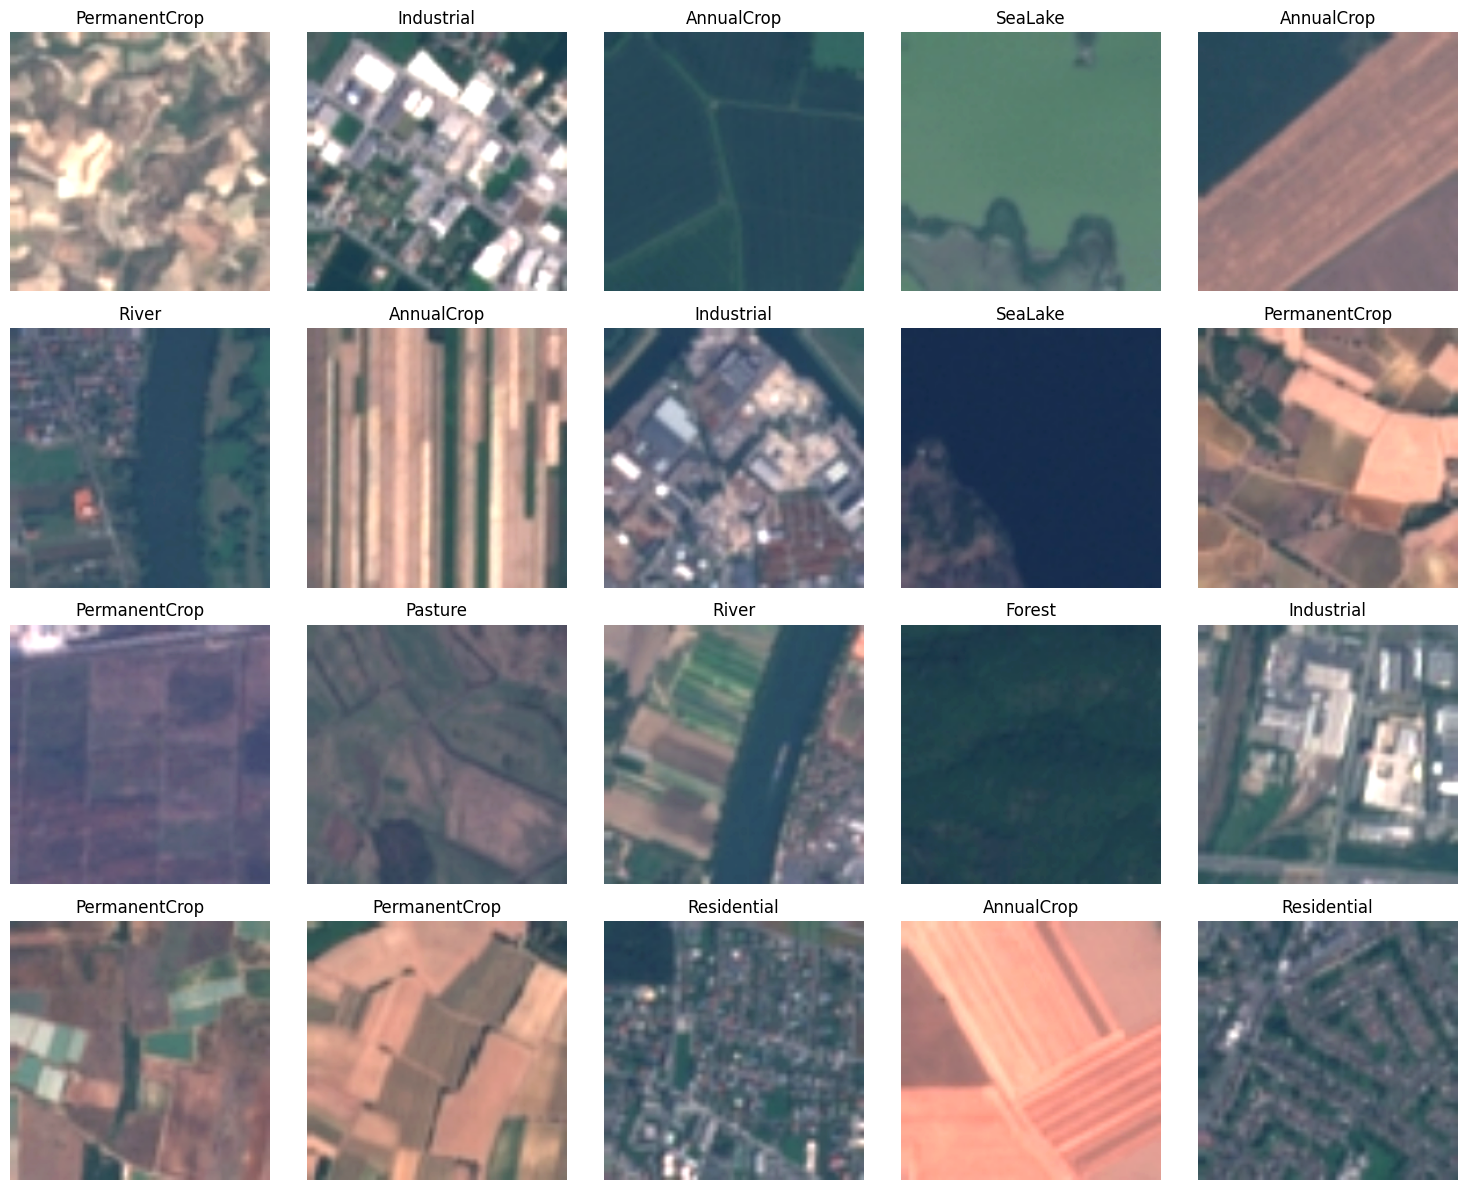

In [18]:
def show_grid(X, y, classes, rows=4, cols=5):
    plt.figure(figsize=(cols*3, rows*3))

    for i in range(rows * cols):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        label = classes[int(y[idx])]

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_grid(X_train, y_train, classes, rows=4, cols=5)

In [20]:
import gc, os
gc.collect()
tf.keras.backend.clear_session()

![](https://www.researchgate.net/publication/376180056/figure/fig3/AS:11431281209199343@1701696914278/GG19-architecture-24.ppm)

Input: 224 × 224 × 3

Block 1 → 112 × 112 × 64  
Block 2 → 56 × 56 × 128  
Block 3 → 28 × 28 × 256  
Block 4 → 14 × 14 × 512  
Block 5 → 7 × 7 × 512  

Flatten → 25088  
FC1 → 4096  
FC2 → 4096  
Output → num_classes
# Building VGG-19 Architecture from Scratch


## research paper: https://arxiv.org/abs/1409.1556

In [22]:
vgg19_model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3), dtype=tf.float32),
    
    # ============ Block 1 (64 filters) ============
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv1'),
    layers.BatchNormalization(name='block1_bn1'),
    layers.Activation('relu', name='block1_relu1'),
    
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv2'),
    layers.BatchNormalization(name='block1_bn2'),
    layers.Activation('relu', name='block1_relu2'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
    
    # ============ Block 2 (128 filters) ============
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv1'),
    layers.BatchNormalization(name='block2_bn1'),
    layers.Activation('relu', name='block2_relu1'),
    
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv2'),
    layers.BatchNormalization(name='block2_bn2'),
    layers.Activation('relu', name='block2_relu2'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
    
    # ============ Block 3 (256 filters) ============
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv1'),
    layers.BatchNormalization(name='block3_bn1'),
    layers.Activation('relu', name='block3_relu1'),
    
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv2'),
    layers.BatchNormalization(name='block3_bn2'),
    layers.Activation('relu', name='block3_relu2'),
    
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv3'),
    layers.BatchNormalization(name='block3_bn3'),
    layers.Activation('relu', name='block3_relu3'),
    
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv4'),
    layers.BatchNormalization(name='block3_bn4'),
    layers.Activation('relu', name='block3_relu4'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
    
    # ============ Block 4 (512 filters) ============
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv1'),
    layers.BatchNormalization(name='block4_bn1'),
    layers.Activation('relu', name='block4_relu1'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv2'),
    layers.BatchNormalization(name='block4_bn2'),
    layers.Activation('relu', name='block4_relu2'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv3'),
    layers.BatchNormalization(name='block4_bn3'),
    layers.Activation('relu', name='block4_relu3'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv4'),
    layers.BatchNormalization(name='block4_bn4'),
    layers.Activation('relu', name='block4_relu4'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),
    
    # ============ Block 5 (512 filters) ============
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv1'),
    layers.BatchNormalization(name='block5_bn1'),
    layers.Activation('relu', name='block5_relu1'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv2'),
    layers.BatchNormalization(name='block5_bn2'),
    layers.Activation('relu', name='block5_relu2'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv3'),
    layers.BatchNormalization(name='block5_bn3'),
    layers.Activation('relu', name='block5_relu3'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv4'),
    layers.BatchNormalization(name='block5_bn4'),
    layers.Activation('relu', name='block5_relu4'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'),
    
    # ============ Fully Connected Layers ============
    layers.Flatten(name='flatten'),
    
    layers.Dense(4096, kernel_initializer='he_normal', name='fc1'),
    layers.BatchNormalization(name='fc1_bn'),
    layers.Activation('relu', name='fc1_relu'),
    layers.Dropout(0.5, name='fc1_dropout'),
    
    layers.Dense(4096, kernel_initializer='he_normal', name='fc2'),
    layers.BatchNormalization(name='fc2_bn'),
    layers.Activation('relu', name='fc2_relu'),
    layers.Dropout(0.5, name='fc2_dropout'),
    
    # Output Layer
    layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')
])

In [23]:
vgg19_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn1 (BatchNormalization) │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn2 (BatchNormalization) │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu2 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn1 (BatchNormalization) │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu1 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn2 (BatchNormalization) │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn1 (BatchNormalization) │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu1 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn2 (BatchNormalization) │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu2 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn3 (BatchNormalization) │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu3 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn4 (BatchNormalization) │ (None, 56, 56, 256)    │         1,02

 Total params: 139,665,994 (532.78 MB)

 Trainable params: 139,638,602 (532.68 MB)

 Non-trainable params: 27,392 (107.00 KB)

## compile

In [25]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 15

vgg19_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vgg19_model.compile(
    optimizer=vgg19_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
vgg19_callbacks = [
    EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='min',
    start_from_epoch=5
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1,
        min_delta=0.0001
    )
]

## Train Model

In [29]:
vgg19_history = vgg19_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=vgg19_callbacks,
    verbose=1
)

Epoch 1/15


I0000 00:00:1765546756.616046     125 service.cc:148] XLA service 0x7eb1a8002dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765546756.616955     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765546758.157459     125 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765546793.043607     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 234s 855ms/step - accuracy: 0.4884 - loss: 1.6006 - val_accuracy: 0.1153 - val_loss: 6.0213 - learning_rate: 1.0000e-04
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 150s 684ms/step - accuracy: 0.6609 - loss: 1.0678 - val_accuracy: 0.3727 - val_loss: 2.6466 - learning_rate: 1.0000e-04
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 154s 703ms/step - accuracy: 0.7144 - loss: 0.9262 - val_accuracy: 0.4287 - val_loss: 2.1691 - learning_rate: 1.0000e-04
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 154s 702ms/step - accuracy: 0.7571 - loss: 0.7532 - val_accuracy: 0.5440 - val_loss: 1.5400 - learning_rate: 1.0000e-04
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 153s 701ms/step - accuracy: 0.7883 - loss: 0.6829 - val_accuracy: 0.5893 - val_loss: 1.5131 - learning_rate: 1.0000e-04
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 156s 711ms/step - accuracy: 0.8179 - loss: 0.5666 - val_accuracy: 0.6167 - val_loss: 1.4194 - learning_rate: 1.0000e-04
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 154s 705ms/

## Evaluation 

In [30]:
y_pred_proba_vgg = vgg19_model.predict(X_test)
y_pred_vgg = np.argmax(y_pred_proba_vgg, axis=1)

# metrics <--------
accuracy_vgg = accuracy_score(y_test, y_pred_vgg)
precision_vgg = precision_score(y_test, y_pred_vgg, average='macro', zero_division=0)
recall_vgg = recall_score(y_test, y_pred_vgg, average='macro', zero_division=0)
f1_vgg = f1_score(y_test, y_pred_vgg, average='macro', zero_division=0)

print(f"VGG-19 Results")
print(f"Accuracy: {accuracy_vgg:.4f}")
print(f"Precision: {precision_vgg:.4f}")
print(f"Recall: {recall_vgg:.4f}")
print(f"F1-Score: {f1_vgg:.4f}")
print(classification_report(y_test, y_pred_vgg, target_names=classes))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step
VGG-19 Results
Accuracy: 0.7127
Precision: 0.7381
Recall: 0.7127
F1-Score: 0.7155
                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.63      0.72       150
              Forest       0.67      0.71      0.69       150
HerbaceousVegetation       0.52      0.76      0.61       150
             Highway       0.80      0.57      0.66       150
          Industrial       0.95      0.85      0.90       150
             Pasture       0.64      0.57      0.60       150
       PermanentCrop       0.55      0.76      0.64       150
         Residential       0.93      0.83      0.88       150
               River       0.71      0.56      0.63       150
             SeaLake       0.76      0.89      0.82       150

            accuracy                  

# Visualizations 

## Training History

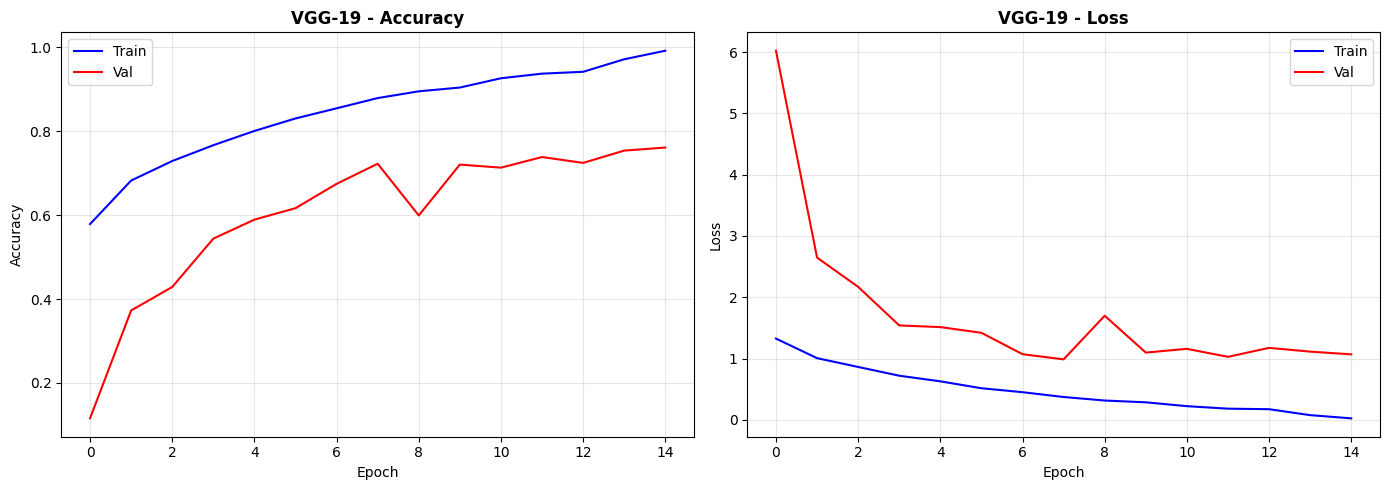

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(vgg19_history.history['accuracy'], 'b-', label='Train')
axes[0].plot(vgg19_history.history['val_accuracy'], 'r-', label='Val')
axes[0].set_title('VGG-19 - Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(vgg19_history.history['loss'], 'b-', label='Train')
axes[1].plot(vgg19_history.history['val_loss'], 'r-', label='Val')
axes[1].set_title('VGG-19 - Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('vgg19_training_history.png', dpi=300)
plt.show()

## Confusion Matrix

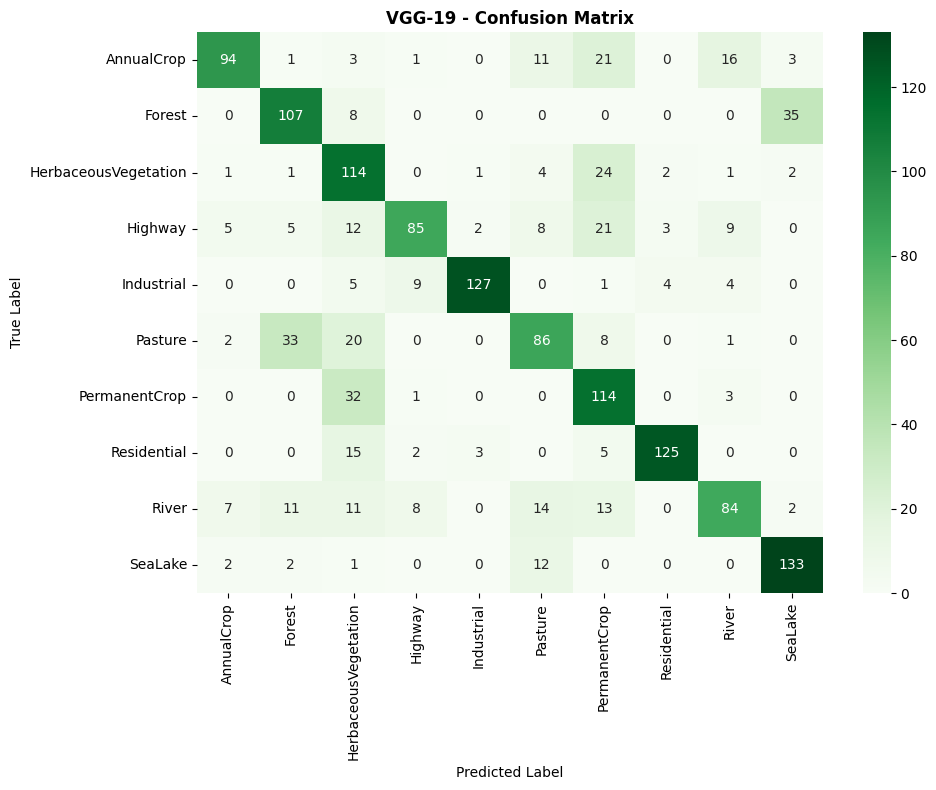

In [32]:
cm_vgg = confusion_matrix(y_test, y_pred_vgg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.title('VGG-19 - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('vgg19_confusion_matrix.png', dpi=300)
plt.show()

## ROC Curves


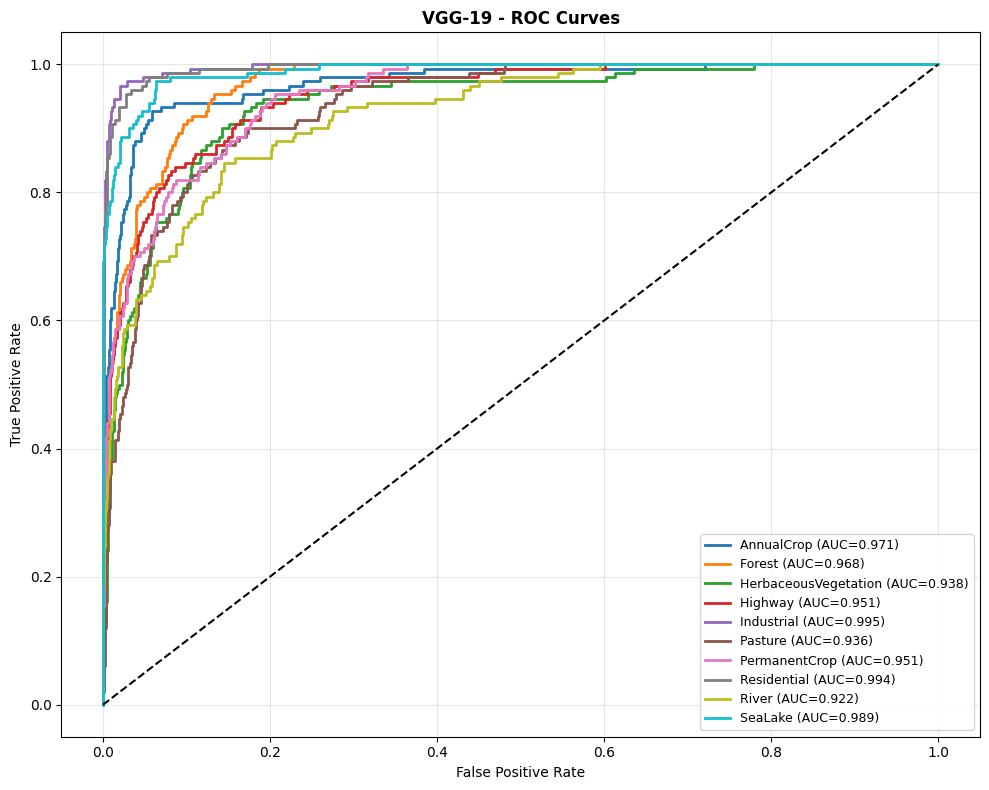


AUC Macro: 0.9615


In [33]:
y_test_bin = label_binarize(y_test, classes=range(num_classes))
plt.figure(figsize=(10, 8))

auc_scores_vgg = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_vgg[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores_vgg.append(roc_auc)
    plt.plot(fpr, tpr, linewidth=2, label=f'{classes[i]} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('VGG-19 - ROC Curves', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('vgg19_roc_curves.png', dpi=300)
plt.show()

print(f"\nAUC Macro: {np.mean(auc_scores_vgg):.4f}")

## Store vgg19 results

In [34]:
vgg19_results = {
    'accuracy': accuracy_vgg,
    'precision': precision_vgg,
    'recall': recall_vgg,
    'f1': f1_vgg,
    'auc_macro': np.mean(auc_scores_vgg),
    'y_pred': y_pred_vgg,
    'y_pred_proba': y_pred_proba_vgg
}

# ResNet-50 (Transfer Learning with Fine-tuning)

In [35]:
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Freeze all layers initially


In [59]:
for layer in resnet_base.layers:
    layer.trainable = False

## Fine-tune
* Unfreeze Conv5_block2 + Conv5_block3 (20 layers)
* This is the optimal block for fine-tuning - last 10 layers

In [60]:
for layer in resnet_base.layers:
    if 'conv5_block3' in layer.name:
        layer.trainable = True

In [61]:
print(f"Total layers: {len(resnet_base.layers)}")
print(f"Trainable layers: {sum([1 for l in resnet_base.layers if l.trainable])}")

Total layers: 176
Trainable layers: 10


## ResNet-50 Layer Structure

In [64]:
print("\n=== Last 15 Layers ===")
for i, layer in enumerate(resnet_base.layers[-15:]):
    print(f"Layer {175-15+i}: {layer.name} - {layer.__class__.__name__}")


=== Last 15 Layers ===
Layer 160: conv5_block2_3_conv - Conv2D
Layer 161: conv5_block2_3_bn - BatchNormalization
Layer 162: conv5_block2_add - Add
Layer 163: conv5_block2_out - Activation
Layer 164: conv5_block3_1_conv - Conv2D
Layer 165: conv5_block3_1_bn - BatchNormalization
Layer 166: conv5_block3_1_relu - Activation
Layer 167: conv5_block3_2_conv - Conv2D
Layer 168: conv5_block3_2_bn - BatchNormalization
Layer 169: conv5_block3_2_relu - Activation
Layer 170: conv5_block3_3_conv - Conv2D
Layer 171: conv5_block3_3_bn - BatchNormalization
Layer 172: conv5_block3_add - Add
Layer 173: conv5_block3_out - Activation
Layer 174: avg_pool - GlobalAveragePooling2D


## Build Model

In [73]:
resnet_model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    resnet_base,
    layers.BatchNormalization(),
    layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,230,154 (100.06 MB)

 Trainable params: 7,100,938 (27.09 MB)

 Non-trainable params: 19,129,216 (72.97 MB)

##  Compile

In [74]:
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## train the model

In [75]:
resnet_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

resnet_history = resnet_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=resnet_callbacks,
    verbose=1
)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.5608 - loss: 3.3700 - val_accuracy: 0.2473 - val_loss: 4.3552 - learning_rate: 1.0000e-04
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.7503 - loss: 2.7302 - val_accuracy: 0.1827 - val_loss: 4.3898 - learning_rate: 1.0000e-04
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.7585 - loss: 2.6183 - val_accuracy: 0.2687 - val_loss: 5.8510 - learning_rate: 1.0000e-04
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.7710 - loss: 2.4972 - val_accuracy: 0.2707 - val_loss: 9.9063 - learning_rate: 1.0000e-04
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.7872 - loss: 2.4014 - val_accuracy: 0.2693 - val_loss: 5.2949 - learning_rate: 1.0000e-04
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7980 - loss: 2.2978
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/ste

## Evaluate

In [76]:
y_pred_proba_resnet = resnet_model.predict(X_test)
y_pred_resnet = np.argmax(y_pred_proba_resnet, axis=1)

# Metrics
accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
precision_resnet = precision_score(y_test, y_pred_resnet, average='macro', zero_division=0)
recall_resnet = recall_score(y_test, y_pred_resnet, average='macro', zero_division=0)
f1_resnet = f1_score(y_test, y_pred_resnet, average='macro', zero_division=0)

print(f"\n{'='*50}")
print(f"ResNet-50 Results")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet:.4f}")
print(f"Recall: {recall_resnet:.4f}")
print(f"F1-Score: {f1_resnet:.4f}")
print(f"{'='*50}")
print(classification_report(y_test, y_pred_resnet, target_names=classes))

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step

ResNet-50 Results
Accuracy: 0.4893
Precision: 0.5045
Recall: 0.4893
F1-Score: 0.4245
                      precision    recall  f1-score   support

          AnnualCrop       0.59      0.73      0.65       150
              Forest       0.00      0.00      0.00       150
HerbaceousVegetation       0.61      0.38      0.47       150
             Highway       0.70      0.15      0.25       150
          Industrial       0.83      0.79      0.81       150
             Pasture       0.50      0.27      0.35       150
       PermanentCrop       0.50      0.51      0.50       150
         Residential       0.38      0.99      0.55       150
               River       0.56      0.06      0.11       150
             SeaLake       0.37      1.00      0.54       150

            accuracy                           0.49      1500
           macro avg       0.50      0.49      0.42      1500
        weighted avg       0.50      0.49      0.42      1500



# Visualizations

## Training History


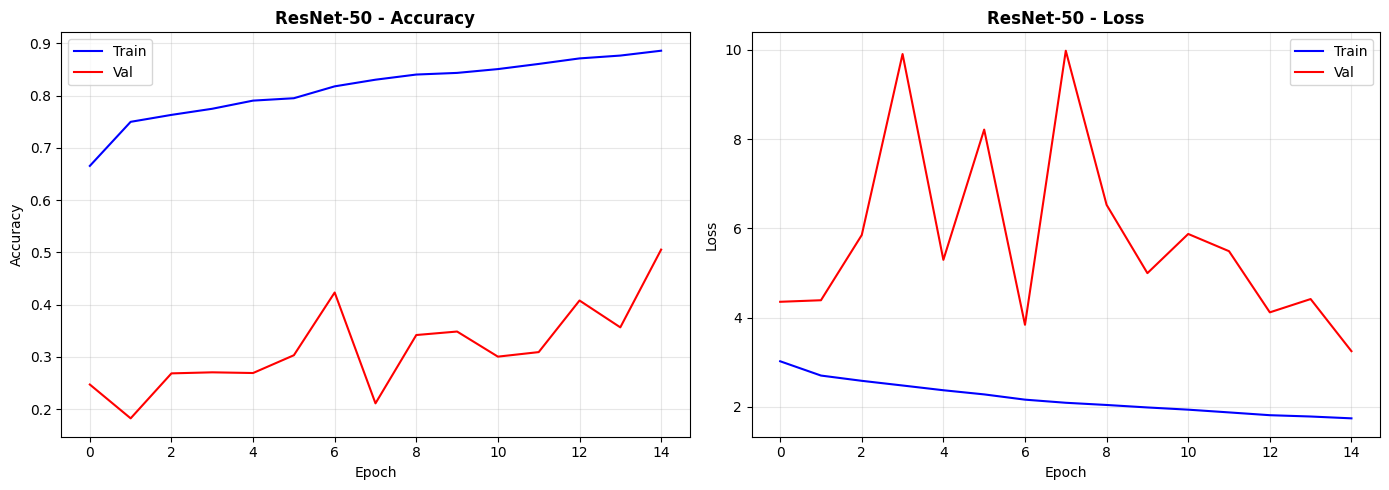

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(resnet_history.history['accuracy'], 'b-', label='Train')
axes[0].plot(resnet_history.history['val_accuracy'], 'r-', label='Val')
axes[0].set_title('ResNet-50 - Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(resnet_history.history['loss'], 'b-', label='Train')
axes[1].plot(resnet_history.history['val_loss'], 'r-', label='Val')
axes[1].set_title('ResNet-50 - Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resnet50_training_history.png', dpi=300)
plt.show()

## Confusion Matrix

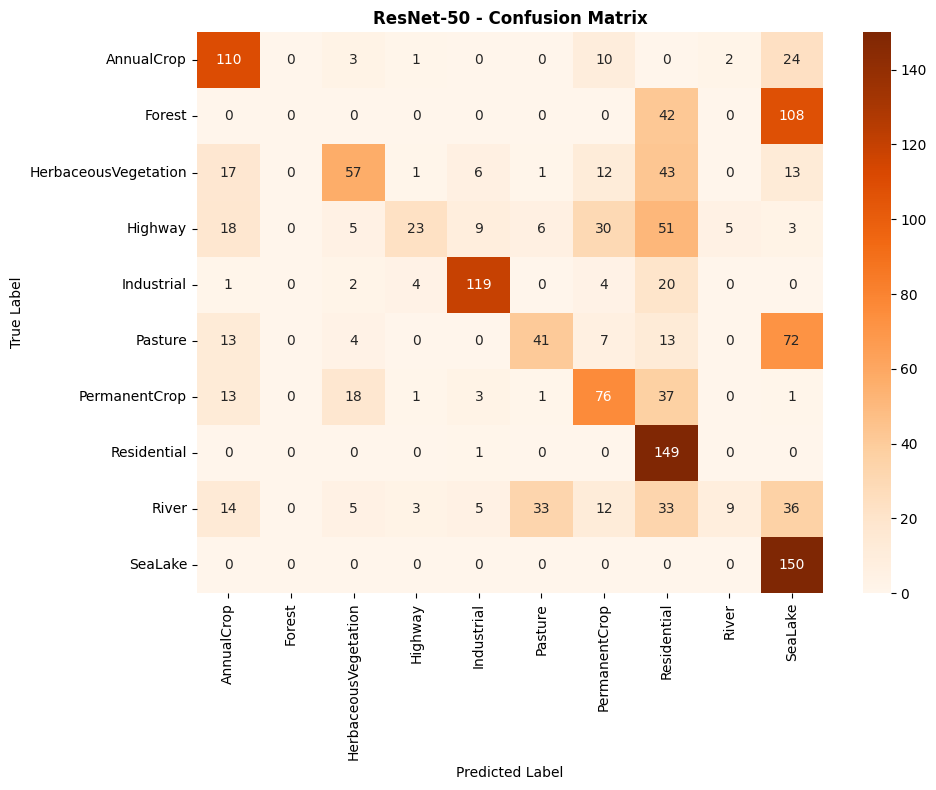

In [78]:
cm_resnet = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Oranges',
            xticklabels=classes, yticklabels=classes)
plt.title('ResNet-50 - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300)
plt.show()

## ROC Curves

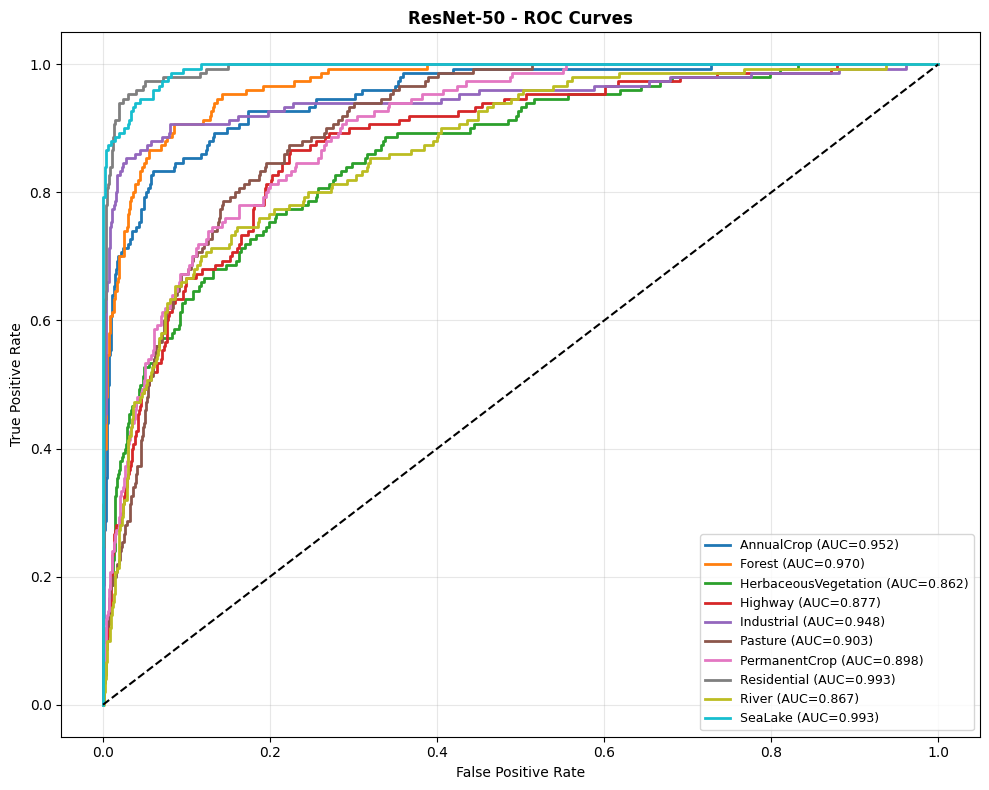


AUC Macro: 0.9264


In [79]:
y_test_bin = label_binarize(y_test, classes=range(num_classes))
plt.figure(figsize=(10, 8))

auc_scores_resnet = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_resnet[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores_resnet.append(roc_auc)
    plt.plot(fpr, tpr, linewidth=2, label=f'{classes[i]} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ResNet-50 - ROC Curves', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resnet50_roc_curves.png', dpi=300)
plt.show()

print(f"\nAUC Macro: {np.mean(auc_scores_resnet):.4f}")

## Store resnet results 

In [80]:
resnet_results = {
    'accuracy': accuracy_resnet,
    'precision': precision_resnet,
    'recall': recall_resnet,
    'f1': f1_resnet,
    'auc_macro': np.mean(auc_scores_resnet),
    'y_pred': y_pred_resnet,
    'y_pred_proba': y_pred_proba_resnet
}

# Inception V1 (Transfer Learning with Fine-tuning)

In [100]:
import tensorflow_hub as hub
INCEPTION_V1_URL = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"

inception_base_model =  hub.KerasLayer(
    INCEPTION_V1_URL,
    trainable=True
)

In [101]:
print(f"Trainable: {inception_base_model.trainable}")

Trainable: True


## Build Model

In [106]:
inputs = tf_layers.Input(shape=(224, 224, 3))
x = inception_base_model(inputs)
x = tf_layers.BatchNormalization()(x)
x = tf_layers.Dense(512, activation='relu')(x)
x = tf_layers.Dropout(0.5)(x)
x = tf_layers.Dense(256, activation='relu')(x)
x = tf_layers.Dropout(0.3)(x)
outputs = tf_layers.Dense(num_classes, activation='softmax')(x)

inception_model = tf_models.Model(inputs=inputs, outputs=outputs)

inception_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1024)              5607184   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                           

In [98]:
import gc, os
gc.collect()
tf.keras.backend.clear_session()

## Compile

In [110]:
inception_model.compile(
    optimizer=tf_optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Train model

In [111]:
inception_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

inception_history = inception_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=inception_callbacks,
    verbose=1
)

Epoch 1/15
219/219 [==============================] - 58s 156ms/step - loss: 1.0575 - accuracy: 0.7163 - val_loss: 0.6420 - val_accuracy: 0.8580 - lr: 1.0000e-04
Epoch 2/15
219/219 [==============================] - 28s 128ms/step - loss: 0.4454 - accuracy: 0.9173 - val_loss: 0.3951 - val_accuracy: 0.9300 - lr: 1.0000e-04
Epoch 3/15
219/219 [==============================] - 28s 129ms/step - loss: 0.3635 - accuracy: 0.9479 - val_loss: 0.3705 - val_accuracy: 0.9313 - lr: 1.0000e-04
Epoch 4/15
219/219 [==============================] - 28s 130ms/step - loss: 0.2955 - accuracy: 0.9640 - val_loss: 0.4039 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 5/15
219/219 [==============================] - 29s 131ms/step - loss: 0.2748 - accuracy: 0.9706 - val_loss: 0.3915 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 6/15
219/219 [==============================] - 29s 132ms/step - loss: 0.2730 - accuracy: 0.9714 - val_loss: 0.3431 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 7/15
219/219 [========

## Evaluate

In [199]:
y_pred_proba_inception = inception_model.predict(X_test)
y_pred_inception = np.argmax(y_pred_proba_inception, axis=1)

# Metrics
accuracy_inception = accuracy_score(y_test, y_pred_inception)
precision_inception = precision_score(y_test, y_pred_inception, average='macro', zero_division=0)
recall_inception = recall_score(y_test, y_pred_inception, average='macro', zero_division=0)
f1_inception = f1_score(y_test, y_pred_inception, average='macro', zero_division=0)

print(f"INCEPTION V1 RESULTS")
print(f"Accuracy:  {accuracy_inception:.4f}")
print(f"Precision: {precision_inception:.4f}")
print(f"Recall:    {recall_inception:.4f}")
print(f"F1-Score:  {f1_inception:.4f}")
print(classification_report(y_test, y_pred_inception, target_names=classes))

47/47 [==============================] - 2s 36ms/step
INCEPTION V1 RESULTS
Accuracy:  0.9667
Precision: 0.9672
Recall:    0.9667
F1-Score:  0.9667
                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.98      0.97       150
              Forest       0.97      1.00      0.99       150
HerbaceousVegetation       0.92      0.95      0.93       150
             Highway       0.97      0.98      0.98       150
          Industrial       0.99      0.99      0.99       150
             Pasture       0.96      0.93      0.94       150
       PermanentCrop       0.93      0.96      0.94       150
         Residential       1.00      0.95      0.98       150
               River       0.98      0.94      0.96       150
             SeaLake       0.99      0.98      0.99       150

            accuracy                           0.97      1500
           macro avg       0.97      0.97      0.97      1500
        weighted avg       0.97      0.97    

# Visualizations

## Training History

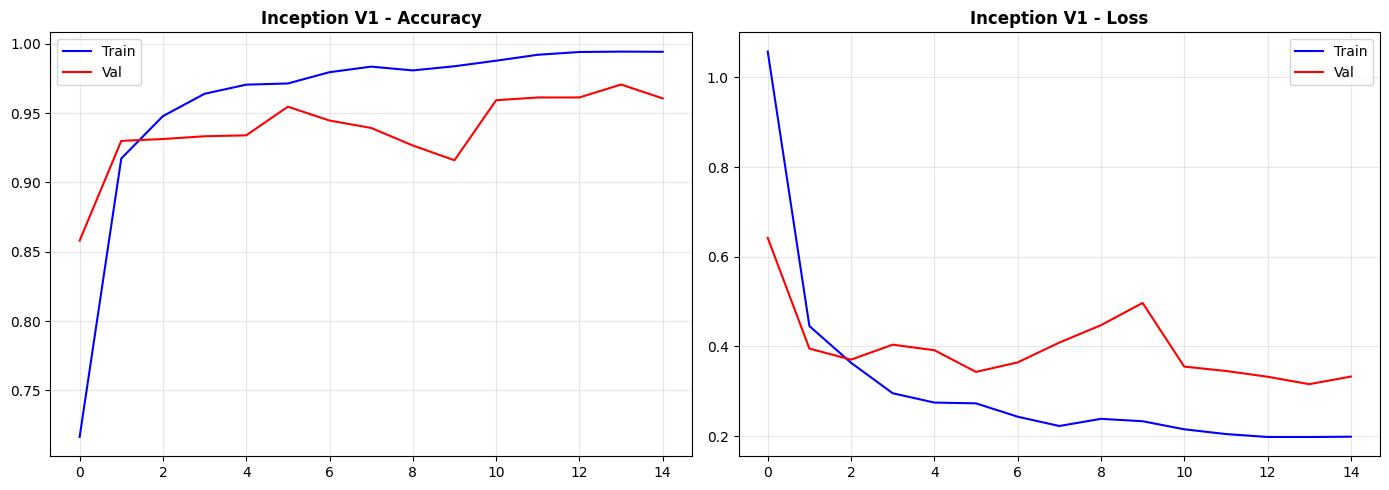

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(inception_history.history['accuracy'], 'b-', label='Train')
axes[0].plot(inception_history.history['val_accuracy'], 'r-', label='Val')
axes[0].set_title('Inception V1 - Accuracy', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(inception_history.history['loss'], 'b-', label='Train')
axes[1].plot(inception_history.history['val_loss'], 'r-', label='Val')
axes[1].set_title('Inception V1 - Loss', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('inception_v1_training_history.png', dpi=300)
plt.show()

## Confusion Matrix


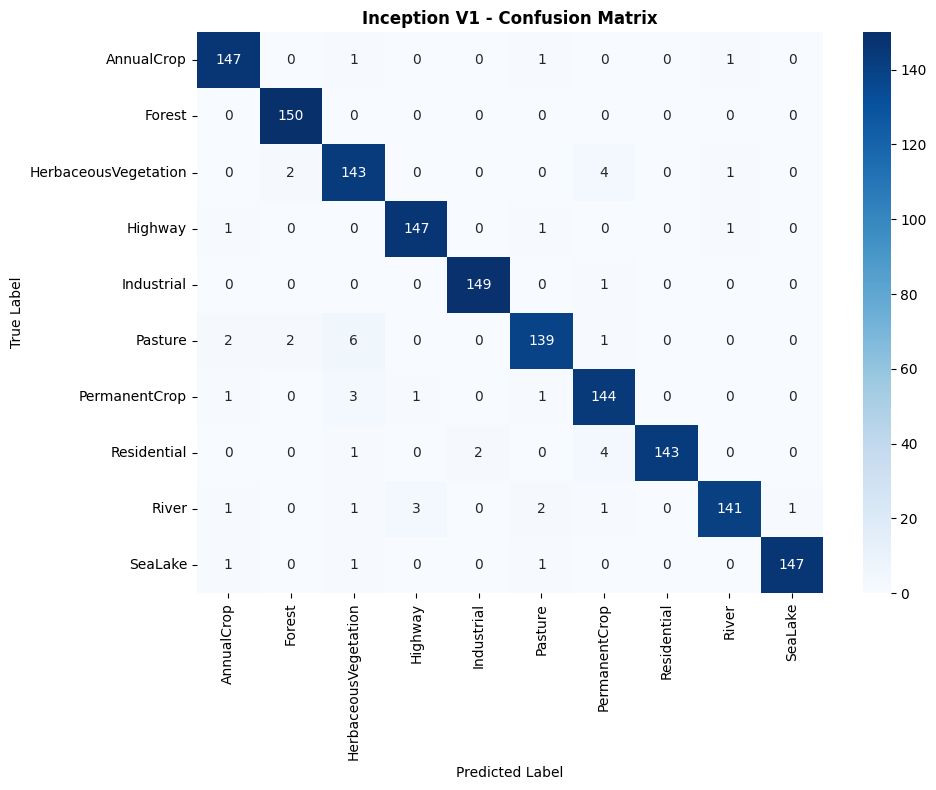

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Inception V1 - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('inception_v1_confusion_matrix.png', dpi=300)
plt.show()

## ROC Curves

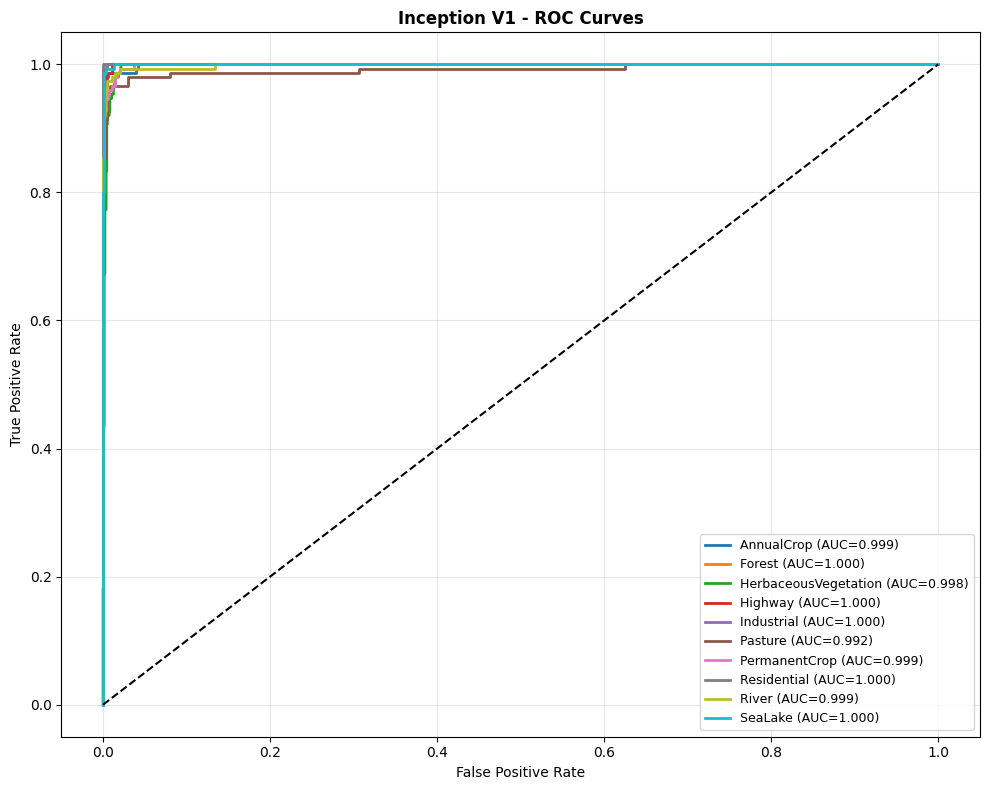


AUC Macro: 0.9986


In [201]:
y_test_bin = label_binarize(y_test, classes=range(num_classes))
plt.figure(figsize=(10, 8))

auc_scores_inception = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_inception[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores_inception.append(roc_auc)
    plt.plot(fpr, tpr, linewidth=2, label=f'{classes[i]} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Inception V1 - ROC Curves', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('inception_v1_roc_curves.png', dpi=300)
plt.show()

print(f"\nAUC Macro: {np.mean(auc_scores_inception):.4f}")

## Store Inception results

In [116]:
inception_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'auc_macro': np.mean(auc_scores),
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba
}

# Store all model

In [ ]:

# # Save individual results
# with open('vgg19_results.pkl', 'wb') as f:
#     pickle.dump(vgg19_results, f)

# with open('resnet_results.pkl', 'wb') as f:
#     pickle.dump(resnet_results, f)

# with open('inception_results.pkl', 'wb') as f:
#     pickle.dump(inception_results, f)

# # Save all results together
# all_results = {
#     'vgg19': vgg19_results,
#     'resnet': resnet_results,
#     'inception': inception_results
# }

# with open('all_results.pkl', 'wb') as f:
#     pickle.dump(all_results, f)

# # Save comparison as CSV
# comparison_data = {
#     'Model': ['VGG-19', 'ResNet-50', 'Inception V1'],
#     'Accuracy': [vgg19_results['accuracy'], resnet_results['accuracy'], inception_results['accuracy']],
#     'Precision': [vgg19_results['precision'], resnet_results['precision'], inception_results['precision']],
#     'Recall': [vgg19_results['recall'], resnet_results['recall'], inception_results['recall']],
#     'F1-Score': [vgg19_results['f1'], resnet_results['f1'], inception_results['f1']],
#     'AUC': [vgg19_results['auc_macro'], resnet_results['auc_macro'], inception_results['auc_macro']]
# }

# print(" All files saved:")
# print("   - vgg19_results.pkl")
# print("   - resnet_results.pkl")
# print("   - inception_results.pkl")
# print("   - all_results.pkl")

In [ ]:
# import pickle
# with open('vgg19_results.pkl', 'wb') as f:
#     pickle.dump(vgg19_results, f)

# with open('resnet_results.pkl', 'wb') as f:
#     pickle.dump(resnet_results, f)

# with open('inception_results.pkl', 'wb') as f:
#     pickle.dump(inception_results, f)

# print("VGG-19, ResNet, Inception results saved!")

## Load Results

In [ ]:
import pickle

# Load all results
# with open('vgg19_results.pkl', 'rb') as f:
#     vgg19_results = pickle.load(f)

# with open('resnet_results.pkl', 'rb') as f:
#     resnet_results = pickle.load(f)

# with open('inception_results.pkl', 'rb') as f:
#     inception_results = pickle.load(f)

# with open('mobilenet_results.pkl', 'rb') as f:
#     mobilenet_results = pickle.load(f)


# MobileNet V2 (Transfer Learning with Fine-tuning)
* MobileNetV2	155	23	Last inverted residual block (block_16)

In [18]:
from tensorflow.keras.applications import MobileNetV2

In [20]:
mobilenet_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

## Freeze all layers initially

In [21]:
for layer in mobilenet_base.layers:
    layer.trainable = False

* Unfreeze the last inverted residual block for fine-tuning
* Last 10 layers (block_16 and conv_1) - optimal for MobileNetV2

In [22]:
for layer in mobilenet_base.layers[-10:]:
    layer.trainable = True

In [23]:
print(f"Total layers: {len(mobilenet_base.layers)}")
print(f"Trainable layers: {sum([1 for l in mobilenet_base.layers if l.trainable])}")

Total layers: 155
Trainable layers: 10


## See last 30 layers

In [24]:
print("\n=== Last 30 Layers ===")
for i, layer in enumerate(mobilenet_base.layers[-20:]):
    idx = len(mobilenet_base.layers) - 30 + i
    trainable = "trainable" if idx >= len(mobilenet_base.layers) - 23 else "freezed"
    print(f"{trainable} Layer {idx}: {layer.name}")


=== Last 30 Layers ===
freezed Layer 125: block_15_expand_BN
freezed Layer 126: block_15_expand_relu
freezed Layer 127: block_15_depthwise
freezed Layer 128: block_15_depthwise_BN
freezed Layer 129: block_15_depthwise_relu
freezed Layer 130: block_15_project
freezed Layer 131: block_15_project_BN
trainable Layer 132: block_15_add
trainable Layer 133: block_16_expand
trainable Layer 134: block_16_expand_BN
trainable Layer 135: block_16_expand_relu
trainable Layer 136: block_16_depthwise
trainable Layer 137: block_16_depthwise_BN
trainable Layer 138: block_16_depthwise_relu
trainable Layer 139: block_16_project
trainable Layer 140: block_16_project_BN
trainable Layer 141: Conv_1
trainable Layer 142: Conv_1_bn
trainable Layer 143: out_relu
trainable Layer 144: global_average_pooling2d_1


## Build Model

In [25]:
mobilenet_model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    mobilenet_base,
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

## Compile

In [26]:
mobilenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Train the model

In [ ]:
import gc
tf.keras.backend.clear_session()
gc.collect()

In [28]:
mobilenet_callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7, 
        verbose=1)
]

mobilenet_history = mobilenet_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=mobilenet_callbacks,
    verbose=1
)

Epoch 1/15


I0000 00:00:1765556584.183844    3274 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765556586.149163    3274 service.cc:148] XLA service 0x7de8b3342a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765556586.149211    3274 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765556586.242613    3274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 [==============================] - 23s 37ms/step - loss: 0.9428 - accuracy: 0.6930 - val_loss: 1.0126 - val_accuracy: 0.6873 - lr: 1.0000e-04
Epoch 2/15
438/438 [==============================] - 12s 28ms/step - loss: 0.5274 - accuracy: 0.8277 - val_loss: 0.6424 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 3/15
438/438 [==============================] - 12s 28ms/step - loss: 0.4155 - accuracy: 0.8664 - val_loss: 0.6281 - val_accuracy: 0.8467 - lr: 1.0000e-04
Epoch 4/15
438/438 [==============================] - 12s 28ms/step - loss: 0.3318 - accuracy: 0.8931 - val_loss: 0.5498 - val_accuracy: 0.8520 - lr: 1.0000e-04
Epoch 5/15
438/438 [==============================] - 12s 28ms/step - loss: 0.3054 - accuracy: 0.8991 - val_loss: 0.5997 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 6/15
438/438 [==============================] - 12s 28ms/step - loss: 0.2778 - accuracy: 0.9047 - val_loss: 0.3788 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 7/15
438/438 [=========================

## Evaluate

In [29]:
y_pred_proba_mobile = mobilenet_model.predict(X_test)
y_pred_mobile = np.argmax(y_pred_proba_mobile, axis=1)

# Metrics
accuracy_mobile = accuracy_score(y_test, y_pred_mobile)
precision_mobile = precision_score(y_test, y_pred_mobile, average='macro', zero_division=0)
recall_mobile = recall_score(y_test, y_pred_mobile, average='macro', zero_division=0)
f1_mobile = f1_score(y_test, y_pred_mobile, average='macro', zero_division=0)

print(f"\n{'='*50}")
print(f"MobileNet V2 Results")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_mobile:.4f}")
print(f"Precision: {precision_mobile:.4f}")
print(f"Recall: {recall_mobile:.4f}")
print(f"F1-Score: {f1_mobile:.4f}")
print(f"{'='*50}")
print(classification_report(y_test, y_pred_mobile, target_names=classes))

47/47 [==============================] - 3s 46ms/step

MobileNet V2 Results
Accuracy: 0.9027
Precision: 0.9072
Recall: 0.9027
F1-Score: 0.9021
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.96      0.93       150
              Forest       0.94      0.89      0.91       150
HerbaceousVegetation       0.77      0.93      0.84       150
             Highway       0.93      0.71      0.80       150
          Industrial       0.99      0.93      0.96       150
             Pasture       0.88      0.90      0.89       150
       PermanentCrop       0.95      0.86      0.90       150
         Residential       0.95      0.97      0.96       150
               River       0.84      0.89      0.86       150
             SeaLake       0.92      0.99      0.95       150

            accuracy                           0.90      1500
           macro avg       0.91      0.90      0.90      1500
        weighted avg       0.91      0.90      0.

# Visualizations

## Training History

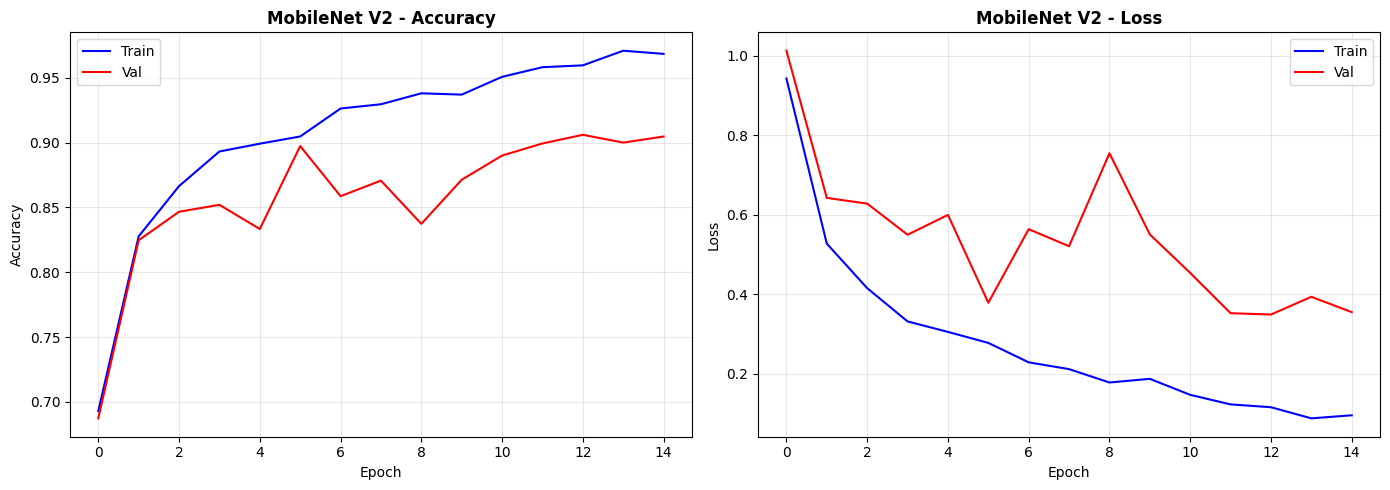

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(mobilenet_history.history['accuracy'], 'b-', label='Train')
axes[0].plot(mobilenet_history.history['val_accuracy'], 'r-', label='Val')
axes[0].set_title('MobileNet V2 - Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(mobilenet_history.history['loss'], 'b-', label='Train')
axes[1].plot(mobilenet_history.history['val_loss'], 'r-', label='Val')
axes[1].set_title('MobileNet V2 - Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mobilenet_v2_training_history.png', dpi=300)
plt.show()

## Confusion Matrix


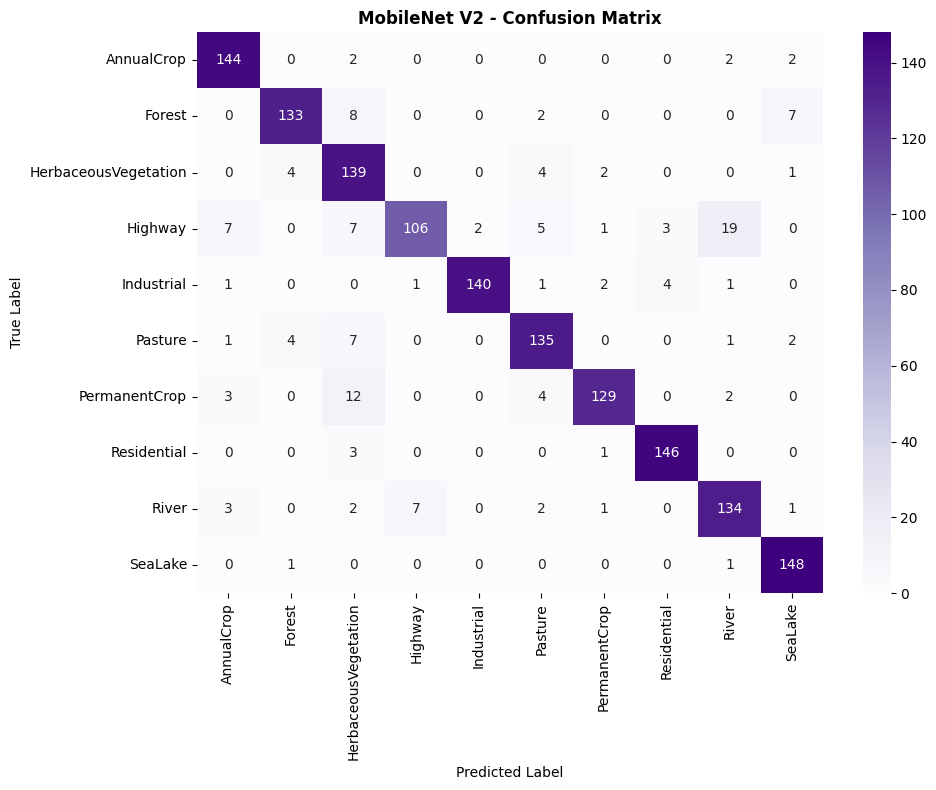

In [31]:
cm_mobile = confusion_matrix(y_test, y_pred_mobile)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mobile, annot=True, fmt='d', cmap='Purples',
            xticklabels=classes, yticklabels=classes)
plt.title('MobileNet V2 - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('mobilenet_v2_confusion_matrix.png', dpi=300)
plt.show()

## ROC Curves


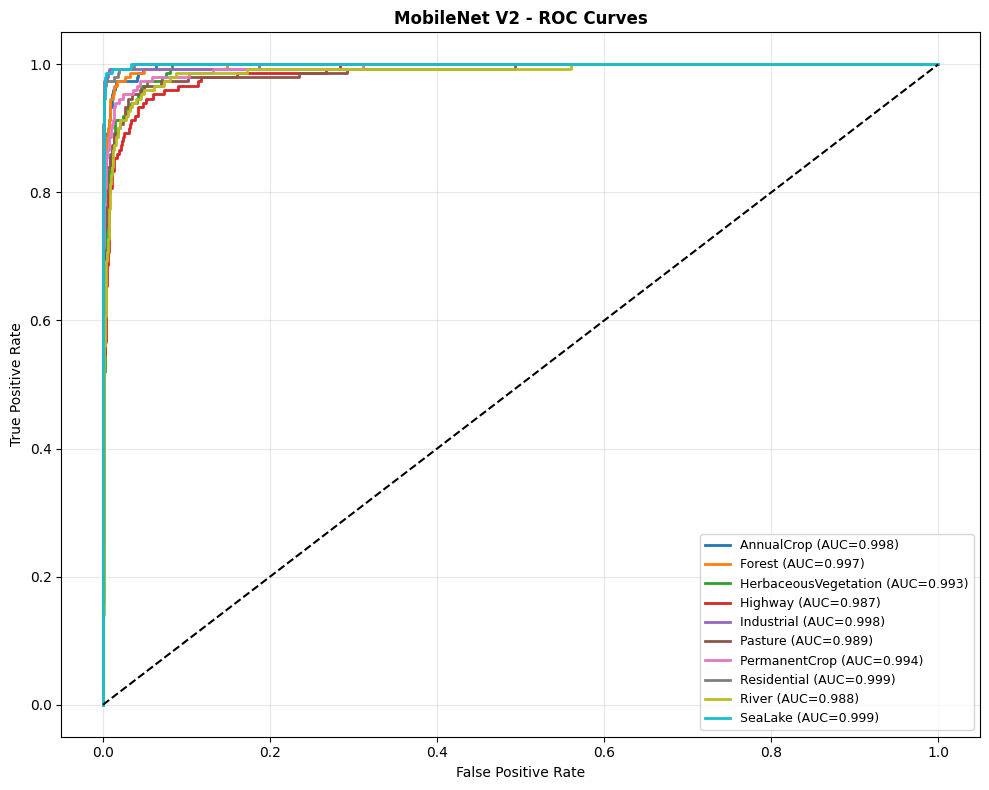


AUC Macro: 0.9943


In [32]:
y_test_bin = label_binarize(y_test, classes=range(num_classes))
plt.figure(figsize=(10, 8))

auc_scores_mobile = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_mobile[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores_mobile.append(roc_auc)
    plt.plot(fpr, tpr, linewidth=2, label=f'{classes[i]} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('MobileNet V2 - ROC Curves', fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mobilenet_v2_roc_curves.png', dpi=300)
plt.show()

print(f"\nAUC Macro: {np.mean(auc_scores_mobile):.4f}")


## Store mobilenet results

In [33]:
mobilenet_results = {
    'accuracy': accuracy_mobile,
    'precision': precision_mobile,
    'recall': recall_mobile,
    'f1': f1_mobile,
    'auc_macro': np.mean(auc_scores_mobile),
    'y_pred': y_pred_mobile,
    'y_pred_proba': y_pred_proba_mobile
}

# Comparative Analysis


## 1. Results Summary Table

In [35]:
comparison_data = {
    'Model': ['VGG-19 (Scratch)', 'Inception V1 (TL)', 'ResNet-50 (TL)', 'MobileNet V2 (TL)'],
    'Accuracy': [vgg19_results['accuracy'], inception_results['accuracy'], 
                 resnet_results['accuracy'], mobilenet_results['accuracy']],
    'Precision': [vgg19_results['precision'], inception_results['precision'],
                  resnet_results['precision'], mobilenet_results['precision']],
    'Recall': [vgg19_results['recall'], inception_results['recall'],
               resnet_results['recall'], mobilenet_results['recall']],
    'F1-Score': [vgg19_results['f1'], inception_results['f1'],
                 resnet_results['f1'], mobilenet_results['f1']],
    'AUC Macro': [vgg19_results['auc_macro'], inception_results['auc_macro'],
                  resnet_results['auc_macro'], mobilenet_results['auc_macro']]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

comparison_df.to_csv('model_comparison_results.csv', index=False)


MODEL COMPARISON SUMMARY
            Model  Accuracy  Precision  Recall  F1-Score  AUC Macro
 VGG-19 (Scratch)    0.7127     0.7381  0.7127    0.7155     0.9615
Inception V1 (TL)    0.9667     0.9672  0.9667    0.9667     0.9986
   ResNet-50 (TL)    0.4893     0.5045  0.4893    0.4245     0.9264
MobileNet V2 (TL)    0.9027     0.9072  0.9027    0.9021     0.9943


## 2. Bar Chart Comparison

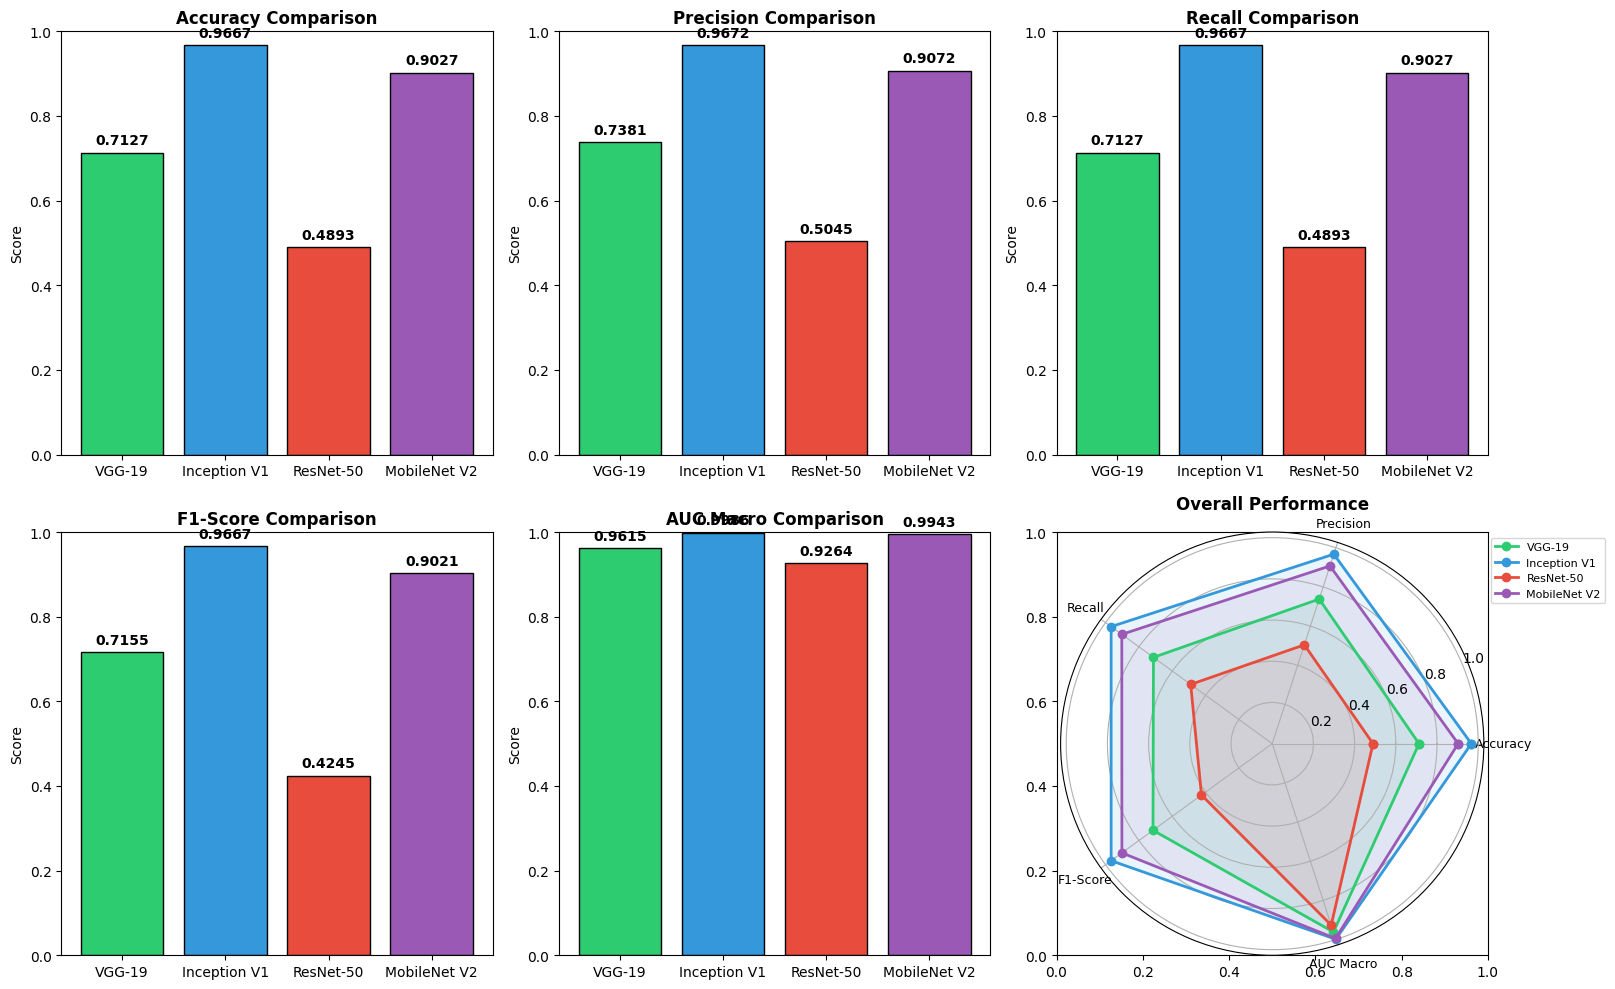

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

models_list = ['VGG-19', 'Inception V1', 'ResNet-50', 'MobileNet V2']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

# Accuracy
axes[0, 0].bar(models_list, comparison_df['Accuracy'], color=colors, edgecolor='black')
axes[0, 0].set_title('Accuracy Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].set_ylabel('Score')
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Precision
axes[0, 1].bar(models_list, comparison_df['Precision'], color=colors, edgecolor='black')
axes[0, 1].set_title('Precision Comparison', fontweight='bold', fontsize=12)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].set_ylabel('Score')
for i, v in enumerate(comparison_df['Precision']):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Recall
axes[0, 2].bar(models_list, comparison_df['Recall'], color=colors, edgecolor='black')
axes[0, 2].set_title('Recall Comparison', fontweight='bold', fontsize=12)
axes[0, 2].set_ylim([0, 1])
axes[0, 2].set_ylabel('Score')
for i, v in enumerate(comparison_df['Recall']):
    axes[0, 2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# F1-Score
axes[1, 0].bar(models_list, comparison_df['F1-Score'], color=colors, edgecolor='black')
axes[1, 0].set_title('F1-Score Comparison', fontweight='bold', fontsize=12)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].set_ylabel('Score')
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# AUC
axes[1, 1].bar(models_list, comparison_df['AUC Macro'], color=colors, edgecolor='black')
axes[1, 1].set_title('AUC Macro Comparison', fontweight='bold', fontsize=12)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].set_ylabel('Score')
for i, v in enumerate(comparison_df['AUC Macro']):
    axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Radar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC Macro']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

ax_radar = fig.add_subplot(2, 3, 6, polar=True)
for idx, model in enumerate(models_list):
    values = comparison_df.iloc[idx, 1:].values.tolist()
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax_radar.fill(angles, values, alpha=0.1, color=colors[idx])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(metrics, fontsize=9)
ax_radar.set_title('Overall Performance', fontweight='bold', fontsize=12)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Combined ROC Curves

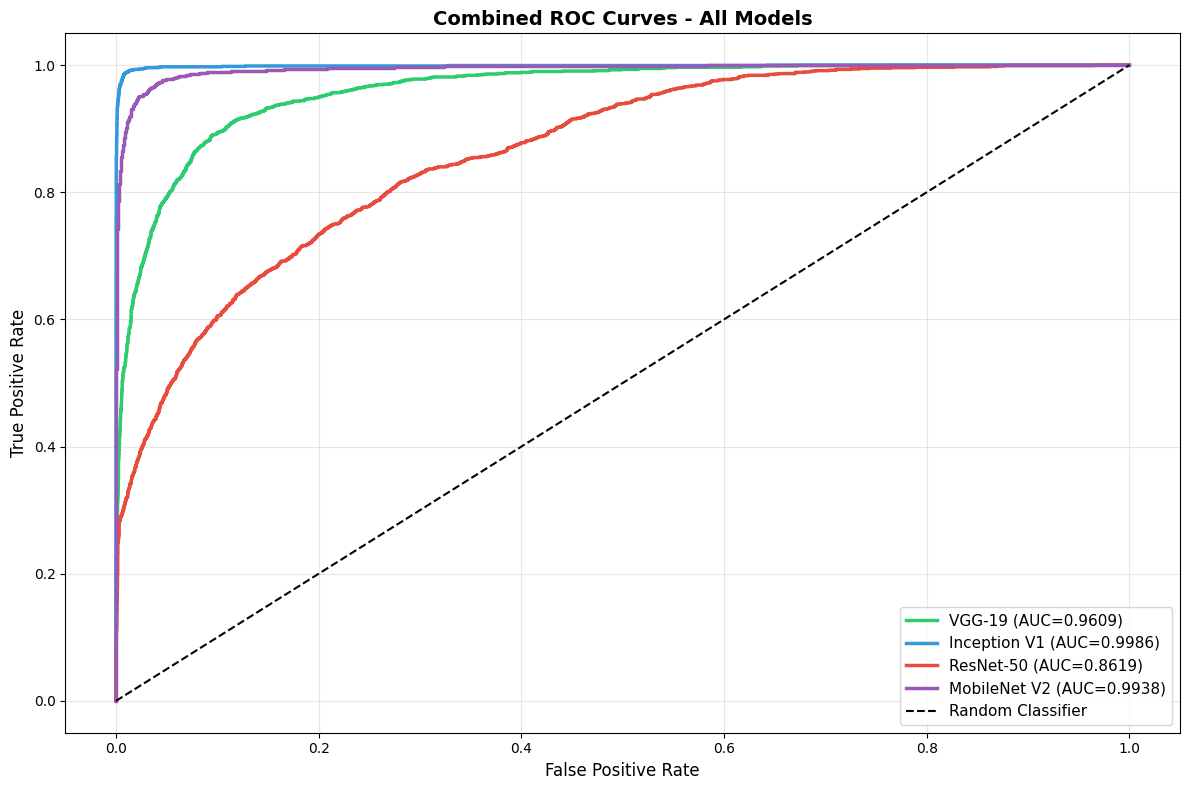

In [40]:
plt.figure(figsize=(12, 8))

all_results_list = [
    (vgg19_results, 'VGG-19', '#2ecc71'),
    (inception_results, 'Inception V1', '#3498db'),
    (resnet_results, 'ResNet-50', '#e74c3c'),
    (mobilenet_results, 'MobileNet V2', '#9b59b6')
]

y_test_bin = label_binarize(y_test, classes=range(num_classes))

for results, name, color in all_results_list:
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), results['y_pred_proba'].ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linewidth=2.5, 
             label=f'{name} (AUC={roc_auc_micro:.4f})', color=color)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
plt.title('Combined ROC Curves - All Models', fontweight='bold', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('combined_roc_curves.png', dpi=300)
plt.show()

## 4. Training History Comparison

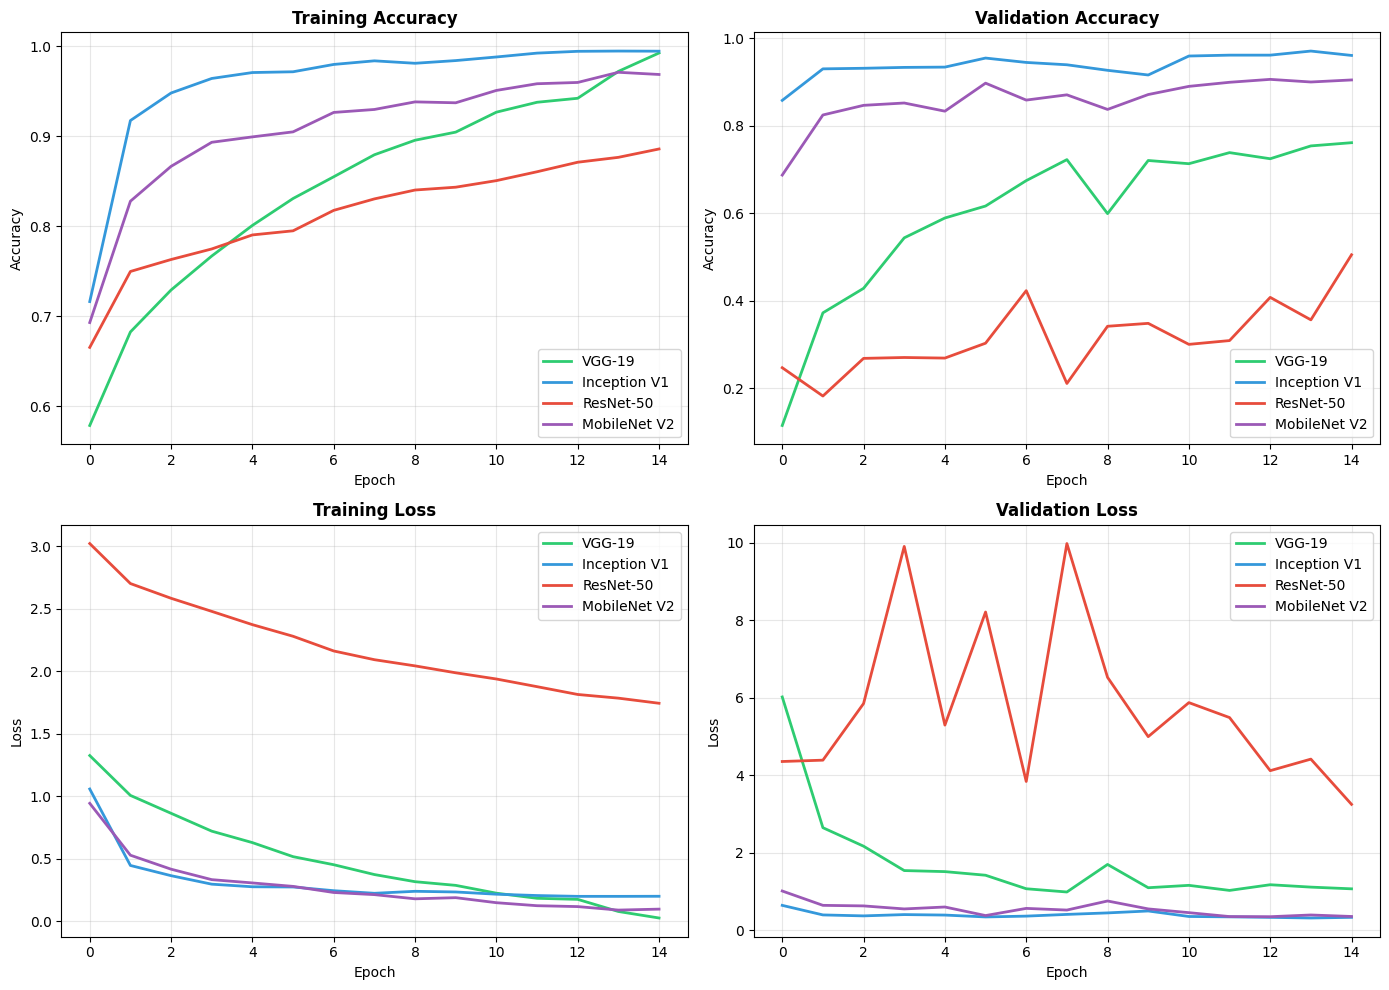

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

histories = [
    (vgg19_results['history'], 'VGG-19', '#2ecc71'),
    (inception_results['history'], 'Inception V1', '#3498db'),
    (resnet_results['history'], 'ResNet-50', '#e74c3c'),
    (mobilenet_history.history, 'MobileNet V2', '#9b59b6')
]

# training Accuracy
for hist, name, color in histories:
    axes[0, 0].plot(hist['accuracy'], linewidth=2, label=name, color=color)
axes[0, 0].set_title('Training Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Val Accuracy
for hist, name, color in histories:
    axes[0, 1].plot(hist['val_accuracy'], linewidth=2, label=name, color=color)
axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# training Loss
for hist, name, color in histories:
    axes[1, 0].plot(hist['loss'], linewidth=2, label=name, color=color)
axes[1, 0].set_title('Training Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Val Loss
for hist, name, color in histories:
    axes[1, 1].plot(hist['val_loss'], linewidth=2, label=name, color=color)
axes[1, 1].set_title('Validation Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_comparison.png', dpi=300)
plt.show()

## 5. Best Model Identification

In [43]:
best_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']

print("\n" + "="*60)
print("BEST PERFORMING MODEL")
print("="*60)
print(f"Model:     {best_model}")
print(f"F1-Score:  {comparison_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"Accuracy:  {comparison_df.loc[best_idx, 'Accuracy']:.4f}")
print(f"AUC:       {comparison_df.loc[best_idx, 'AUC Macro']:.4f}")


BEST PERFORMING MODEL
Model:     Inception V1 (TL)
F1-Score:  0.9667
Accuracy:  0.9667
AUC:       0.9986
